In [1]:


import matplotlib.pyplot as plt
import numpy as np

from qutip import*
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap as lsc
import time
from matplotlib import gridspec
import scipy.optimize as opt
from tcsim.analyze.dataloader import*
from tcsim.analyze.fit_funcs.char_func_cat import char_func_cat



# Everything in plae to be able to manipulate it quickly here if  needed.


N = 40
## cavity operators
a = tensor(destroy(N), qeye(2))
## qubit operator 
def char_func_grid(state, xvec):
    """Calculate the Characteristic function as a 2Dgrid (xvec, xvec) for a given state.

    Args:
        state (Qobject): State of which we want to calc the charfunc
        xvec (_type_): array of displacements. The char func will be calculated for the grid (xvec, xvec)

    Returns:
        tuple(ndarray, ndarray): Re(char func), Im(char func)
    """
    cfReal = np.empty((len(xvec),len(xvec)))
    cfImag = np.empty((len(xvec),len(xvec)))

    for i, alpha_x in enumerate(xvec):
        for j, alpha_p in enumerate(xvec):
            expect_value = expect(displace(N, alpha_x +1j*alpha_p),state)
            cfReal[i,j] =  np.real(expect_value)
            cfImag[i,j] =  np.imag(expect_value)

    return cfReal,cfImag  

def calc_squeez_parameter(dB):
    return np.log(10**(dB/10))/2

from scipy.interpolate import interp2d
def cut_indexes(y_inter,angle):
    k = np.tan(angle)
    max_y_index = np.max(y_inter) # define maximal y_index allowed
    max_x_index = max_y_index
    xvec_fine = np.linspace(0, max_x_index, len(y_inter))
    for i, x in enumerate(xvec_fine):
        if np.abs(x*k)>max_y_index:
            max_x_index = xvec_fine[i-1]
            break
    x_indicies = np.linspace(-max_x_index, max_x_index, len(y_inter))
    y_indicies = x_indicies*k
    return x_indicies, y_indicies
    
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def gauss_1(x, amp1, cen1, sigma1):
    return amp1 * (np.exp((-1.0 / 2.0) * (((x - cen1) / sigma1) ** 2)))

def gauss_3(x, amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3):
    """ Fitting Function"""
    return amp1 * (np.exp((-1.0 / 2.0) * (((x - cen1) / sigma1) ** 2))) + \
           amp2 * (np.exp((-1.0 / 2.0) * (((x - cen2) / sigma2) ** 2))) + \
           amp3 * (np.exp((-1.0 / 2.0) * (((x - cen3) / sigma3) ** 2)))
           
def char_func_cat(xy_tuple, amplitude, sigma_x,sigma_y, beta_amp, theta, offset):
    theta = theta+np.pi/2
    (x,y) = xy_tuple
    alpha = x+1j*y
    
    beta = beta_amp*np.exp(-1j*theta)
    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2) 
    
    g = offset + amplitude*np.exp( - (a*((x)**2) + 2*b*(x)*(y) 
                            + c*((y)**2)))*np.real(np.exp(np.conjugate(alpha)*beta-np.conjugate(beta)*alpha)) - np.exp(-np.abs((np.sqrt(2)*beta + alpha/(np.sqrt(2)))**2)) - np.exp(-np.abs((np.sqrt(2)*beta - alpha/(np.sqrt(2)))**2))
    return g.ravel()

def char_func_fringe(xy_tuple, amplitude, sigma_x,sigma_y, beta_amp, theta, offset):
    theta = theta+np.pi/2
    (x,y) = xy_tuple
    alpha = x+1j*y
    beta = beta_amp*np.exp(-1j*theta)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2) 
    
    g = offset + amplitude*np.exp( - (a*((x)**2) + 2*b*(x)*(y) 
                            + c*((y)**2)))*np.real(np.exp(np.conjugate(alpha)*beta-np.conjugate(beta)*alpha))
    return g.ravel()
    
    

C:\Users\jonat\Desktop\Coding\tcsim\tcsim\analyze\dataloader.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dg = np.array(dg)
C:\Users\jonat\Desktop\Coding\tcsim\tcsim\analyze\dataloader.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  de = np.array(de)


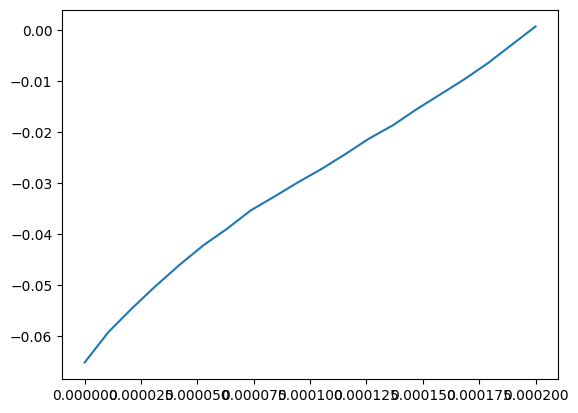

In [3]:
from scipy.optimize import curve_fit


path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/"
file_end = 'panther_sq_vcat_6db_oddcat.h5'

thresholds = np.linspace(0,2e-4, 20)
floor_values = []
for threshold in thresholds:
    xvec, yvec, data_array, decay_times = load_triple_mask_decay(path, file_end ,thresh=threshold, plot=False)
    floor_values.append(data_array[0][0:5,:].mean())
    
plt.plot(thresholds,floor_values)

[ 3.07563885e+02 -6.02704214e-02]


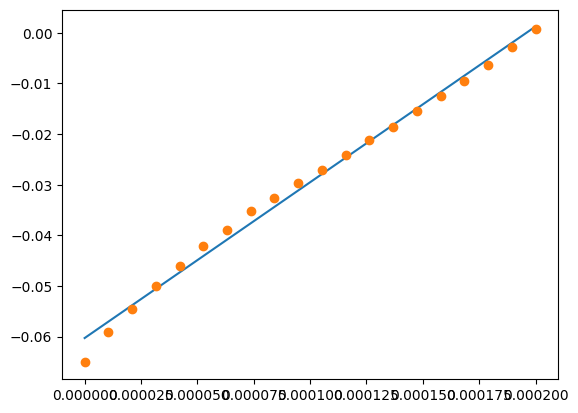

In [4]:
from scipy.optimize import curve_fit

def line(x, m, y):
    return x*m+y
popt, pcov = opt.curve_fit(line, thresholds, floor_values, p0= [0,0])
print(popt)
plt.plot(thresholds,line(np.array(thresholds),*popt))
plt.plot(thresholds,floor_values, 'o')
thresh = (-popt[1]/popt[0])

C:\Users\jonat\Desktop\Coding\tcsim\tcsim\analyze\dataloader.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dg = np.array(dg)
C:\Users\jonat\Desktop\Coding\tcsim\tcsim\analyze\dataloader.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  de = np.array(de)


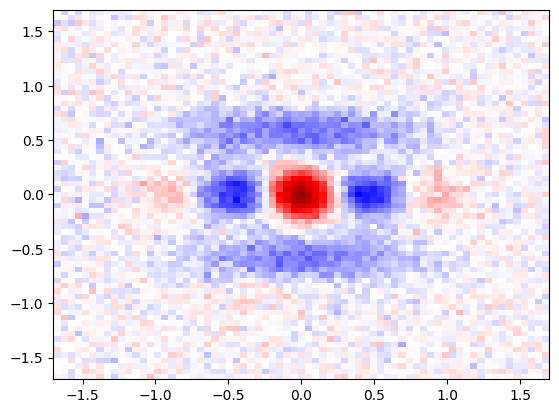

In [7]:
xvec, yvec, data_array, decay_times = load_triple_mask_decay(path, file_end ,thresh=thresh, plot=False)

xvec = np.linspace(-1.7, 1.7, 70)
plt.pcolormesh(xvec,xvec,data_array[0],vmin = -1, vmax = 1, cmap="seismic")


### Load cat data

In [8]:
path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/"
file_end = 'decay_loop_oddcat.h5'
x, y, data_array, decay_times = load_triple_mask_decay(path, file_end , thresh = thresh,plot=False)

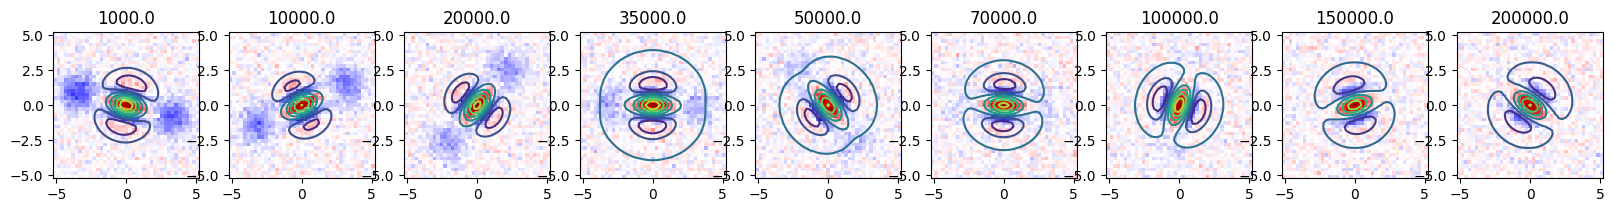

In [9]:
fig, axs = plt.subplots(1, len(data_array), figsize = (20, 20*len(data_array)))

popts = []
angles_cat = []
angles_guess = [0.2+np.pi/2, np.pi/2, 0 ,np.pi/2 ,np.pi/2 ,np.pi/2 ,0 ,np.pi/2 ,np.pi/2]
for i, data in enumerate(data_array):
    scaling = 3
    xvec = x*scaling # i define it like this in case i want to slice x
    yvec = x*scaling
    X, Y = np.meshgrid(yvec, xvec)

    #(xy_tuple, amplitude, sigma_x, sigma_y, beta_amp, theta, offset)
    initial_guess = (0.8,  0.8, 1, 1, angles_guess[i], 0) # upper blob

        
    popt, pcov = opt.curve_fit(char_func_cat, (X, Y), data.flatten(), p0=initial_guess)
    popts.append(popt)
    angles_cat.append(popt[4])

    data_fitted1 = char_func_cat((X, Y), *popt)

    axs[i].pcolormesh(X,Y, data, cmap="seismic", vmin = -1 , vmax = 1)
    axs[i].contour(yvec,xvec, data_fitted1.reshape(X.shape))
    axs[i].set_aspect("equal")
    axs[i].set_title(str(decay_times[i]))
plt.show()

In [10]:
print("First Blob")
print('amplitude:',popts[0][0])
print('sigmax:',popts[0][1])
print('sigmay:',popts[0][2])
print('beta:',popts[0][3] )
print("theta:",(popts[0][4]))
print("offset:",(popts[0][5]))


First Blob
amplitude: 2.2639699319864897
sigmax: 0.9750853350960089
sigmay: -0.87458414750353
beta: 0.12082803413168383
theta: 1.822390830697901
offset: -0.021801995043648912


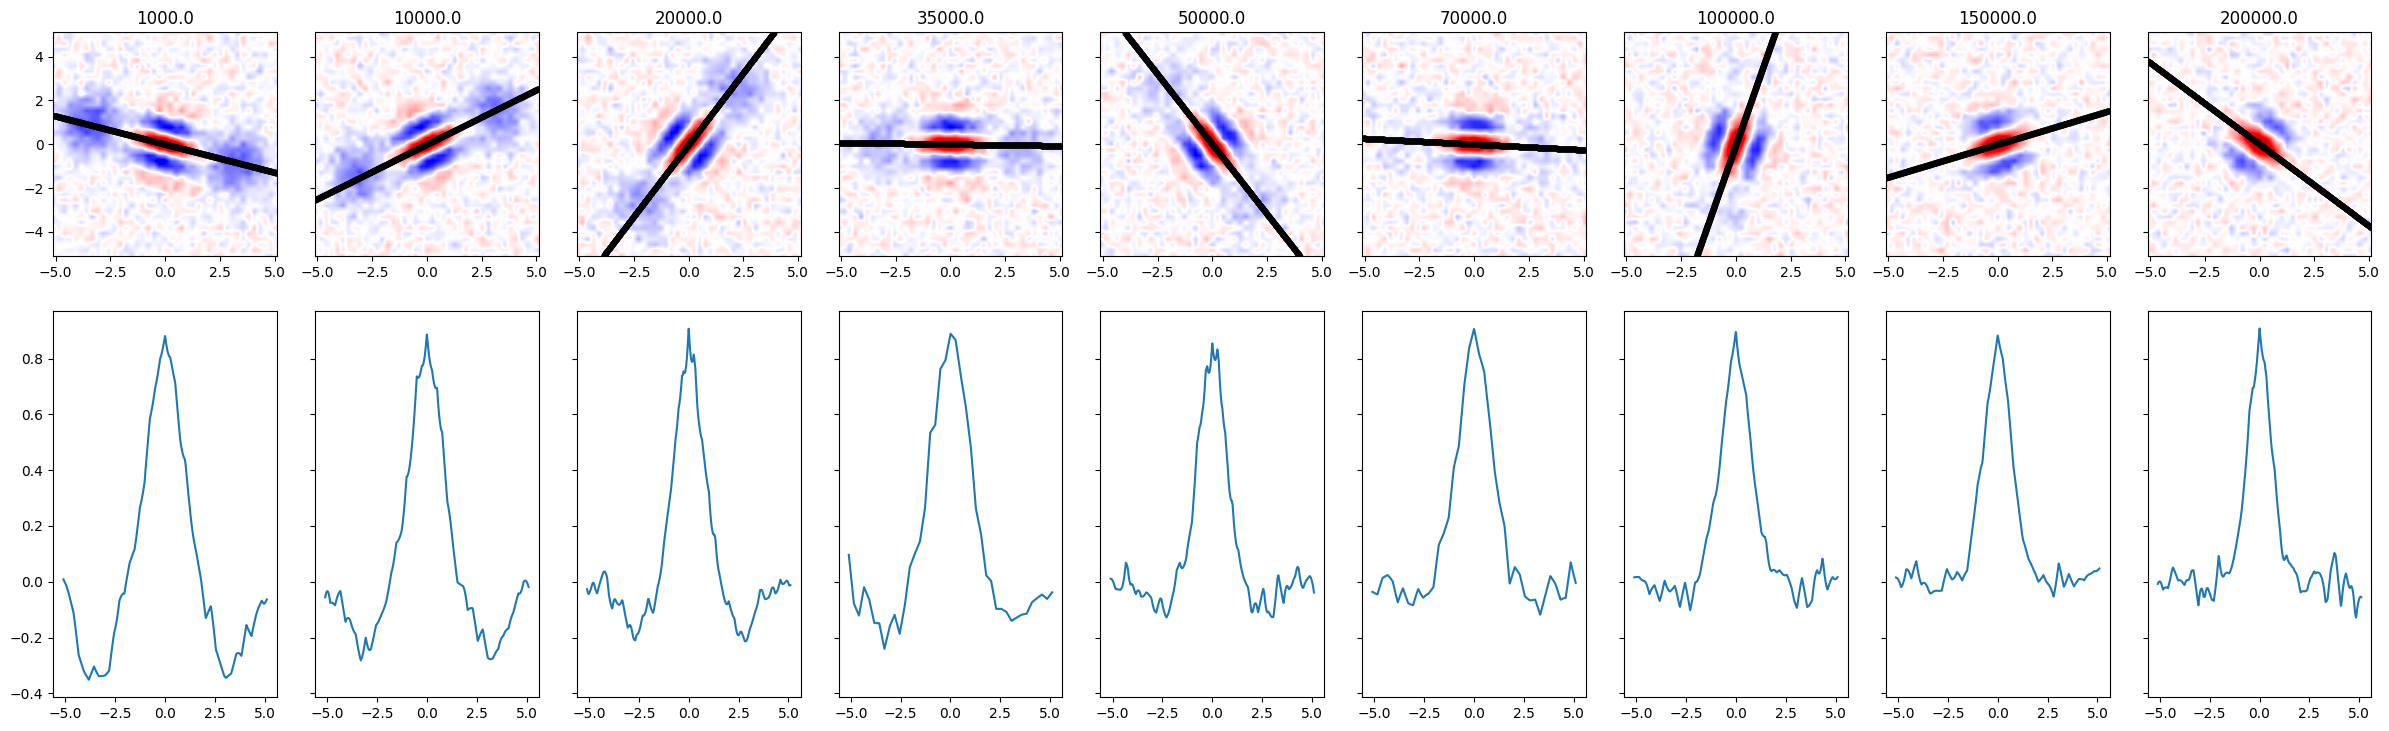

In [11]:

fig, axs = plt.subplots(2,len(data_array), sharey="row", figsize=(24,8))

cat_cut_array = []
for i, data in enumerate(data_array):
    angle = angles_cat[i]
    if np.abs(angles_cat[i])<np.deg2rad(15):
        data = data.T
        angle = np.pi/2-angles_cat[i]
    #interpolate data
    func = interp2d(xvec,yvec,data, kind="linear")
    # define finer x,y arrays with same end values as data x,y
    x_inter = np.linspace(np.min(xvec),np.max(xvec), 1000)
    y_inter = np.linspace(np.min(xvec),np.max(xvec), 1000)
    
    # get x and y indicies for line cut and load the line cut in cut
    x_index, y_index = cut_indexes(y_inter, np.pi/2-angle)
    cut = []
    for j in range(len(x_index)):
        cut.append(float(func(x_index[j],y_index[j])))
    cat_cut_array.append(cut)

    axs[0][i].set_aspect("equal")
    axs[0][i].pcolormesh(x_inter, y_inter, func(x_inter,x_inter), vmin=-1, vmax=1 , cmap="seismic")
    axs[0][i].scatter(x_index, y_index, c='k', marker = '.')
    axs[0][i].set_title(str(decay_times[i]))
    axs[1][i].plot(x_inter,cut)
    plt.tight_layout()
plt.show()
    


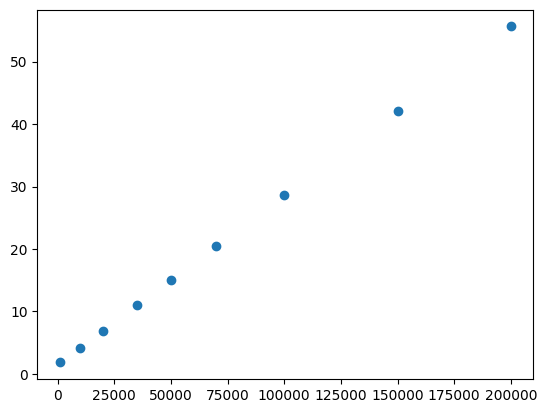

In [8]:
pis = np.array([0,1,2,3,4,6,9,13,17])*np.pi
fit_angles = np.array(angles_cat) + pis
plt.plot(decay_times, fit_angles, 'o')

In [14]:
angles_cat

[1.8368125770609065,
 1.0878071559804525,
 0.6362315682412671,
 1.5814782183847496,
 2.4724236671499096,
 1.6144707651557353,
 0.33570862810170893,
 1.2760426952314499,
 2.2082325439893444]

f= 43046.158245343184
theta = 1.5355331947988828


Text(0.5, 1.0, 'cat')

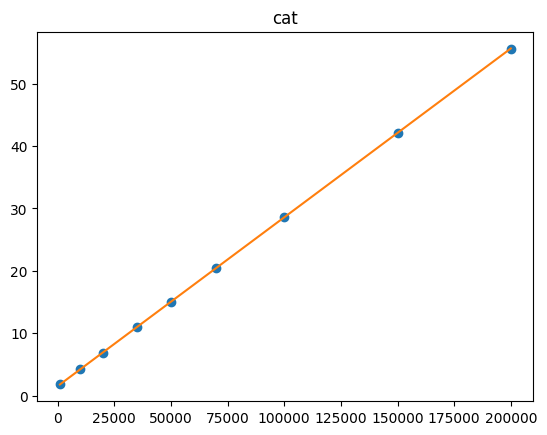

In [109]:
from scipy.optimize import curve_fit

def func(t,f,theta):
    return 2*np.pi*f*t+theta

popt, pcov = curve_fit(func,decay_times[:],fit_angles[:])

plt.plot(decay_times[:],fit_angles[:], "o")
plt.plot(decay_times[:],func(decay_times[:], *popt), )
print("f=", popt[0]*1e9)
print("theta =", popt[1])
plt.title("cat")

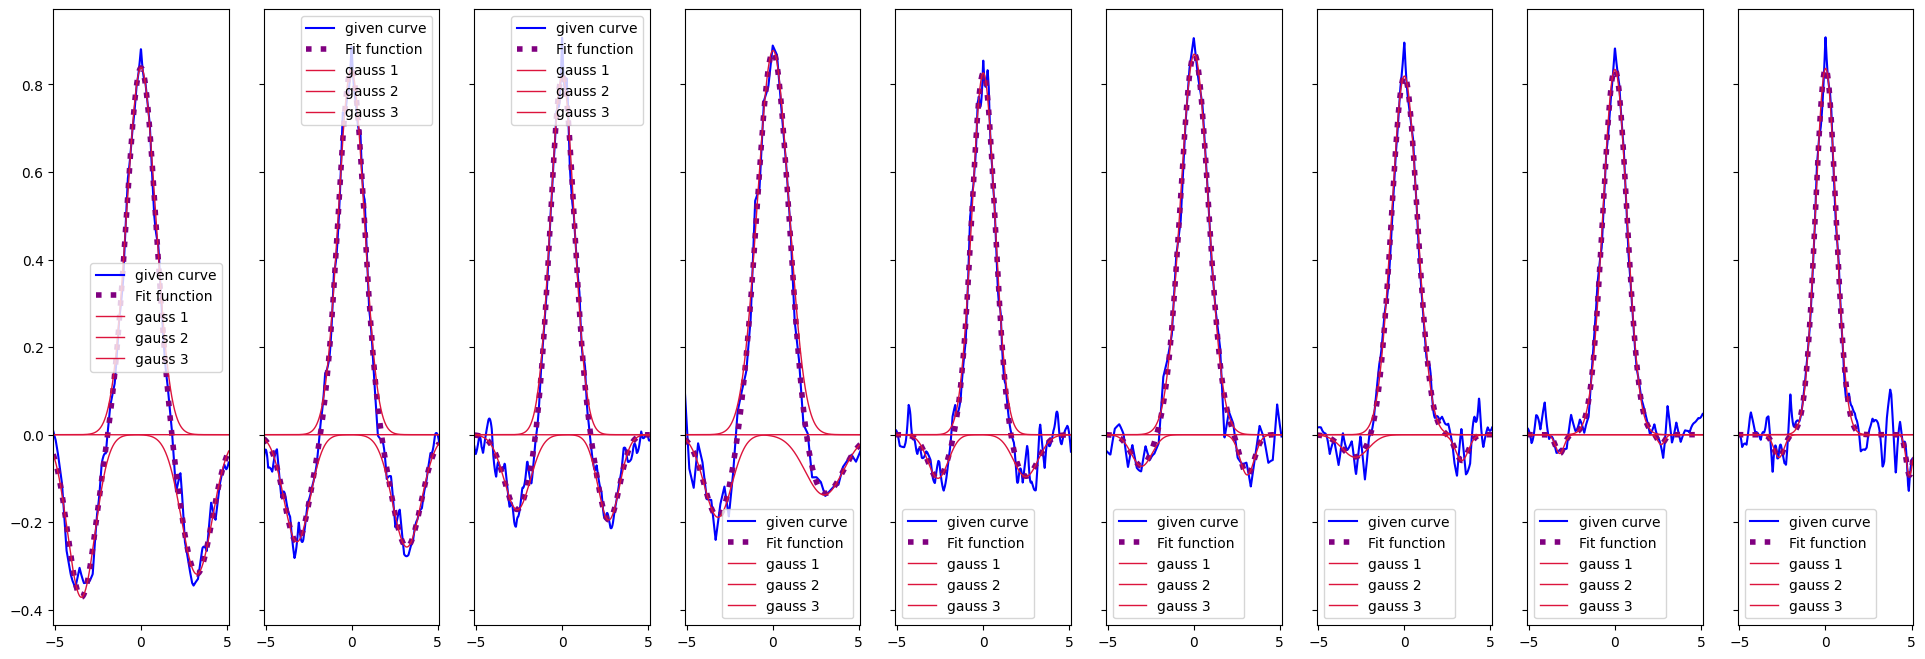

In [12]:

fig, axs = plt.subplots(1,len(cat_cut_array), sharey="row", figsize=(24,8))

fit_amp_cat = []
fit_amp_std_cat = []
for i, cut in enumerate(cat_cut_array):
    amp1 = -0.4
    sigma1 = 0.8
    cen1 = -3.5
    amp2 = 0.
    sigma2 = 1
    cen2 = 0
    amp3 = -0.4
    sigma3 = 0.9
    cen3 = 3.5
    initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
    bounds =([-1, -5, 0.2 ,0, -0.5, 0 ,-1,0, 0.2], 
             [0, 0, 1.1 ,1, 0.5, 1.1 ,0, 5, 1.1])
       
    
    x = np.array(x_inter)
    y = np.array(cut)
    
    y0 = gauss_3(x, *initial_guess)

    popt, pcov = curve_fit(gauss_3, x, y, p0=initial_guess, bounds=bounds)
    fit_amp_cat.append((popt[0]+popt[6])/2)
    fit_amp_std_cat.append(np.sqrt(pcov[0][0]+pcov[6][6])/2) # take square root of averaged variances to find the std 
    
    axs[i].plot(x, y, 'b', label="given curve")
    axs[i].plot(x, gauss_3(x, *popt), ls=':', label="Fit function", linewidth=4, color='purple')
    for j, (a, c, s )in enumerate( popt.reshape(-1, 3)):
        axs[i].plot(x, gauss_1(x, a, c, s), ls='-', label=f"gauss {j+1}", linewidth=1, color='crimson')
    axs[i].legend()
    axs[i].autoscale(axis='x', tight=True)
plt.show()


<ErrorbarContainer object of 3 artists>

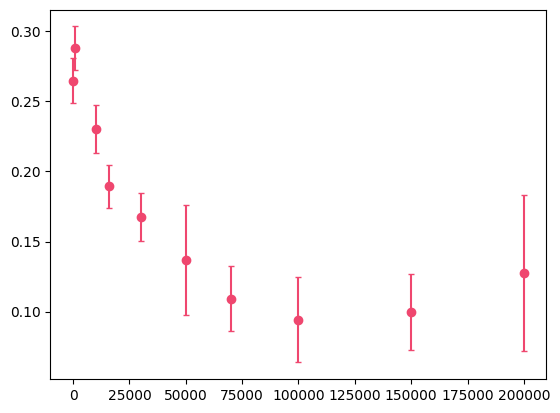

In [49]:
data = np.load('bootstrap_blob_amps.npz')
cat_blob_amps = data["cat_blob_amps"]
times = data["decay_times"]
error_bars = data["error_bars"]

fig1, ax = plt.subplots()

ax.errorbar(times[:], cat_blob_amps[0],yerr=error_bars[0],fmt= 'o', label = '0dB', capsize = 2, color = '#ef476f')


In [15]:
decay_times

array([  1000.,  10000.,  20000.,  35000.,  50000.,  70000., 100000.,
       150000., 200000.])

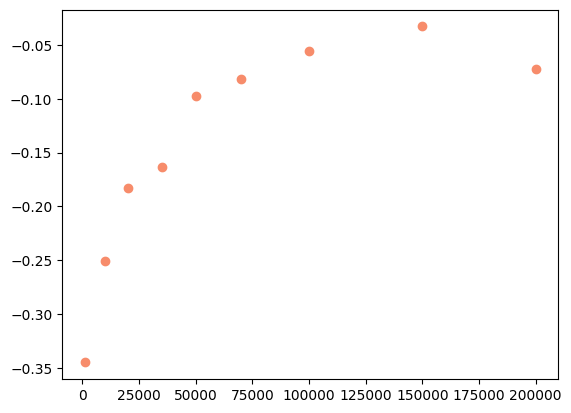

In [13]:

plt.plot(decay_times[:],np.array(fit_amp_cat[:]), "o", label = "odd cat",color = '#f78c6b'  )
# plt.plot(times[:], cat_blob_amps[0], "+", label = 'even cat',  color = 'blue')
# plt.legend()

In [14]:
fit_amp_cat

[-0.34495980301566864,
 -0.2505765436899787,
 -0.18318040303069405,
 -0.1631226396431858,
 -0.0977318296505042,
 -0.08196888752774983,
 -0.055245631730886105,
 -0.03276571707297555,
 -0.07245987566924936]

## 3 dB

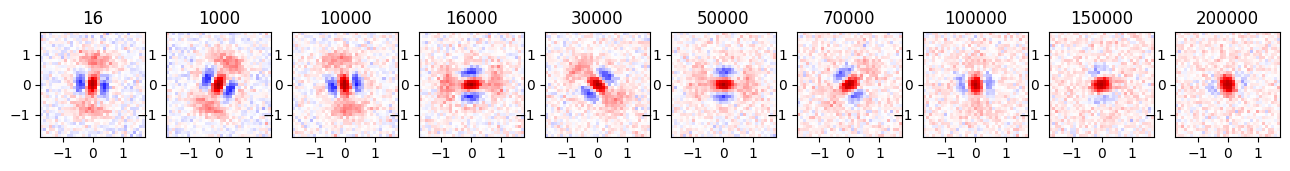

In [53]:
path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data/"
file_end = '3db.h5'
x, y, data_array, decay_times = load_triple_mask_decay(path, file_end)

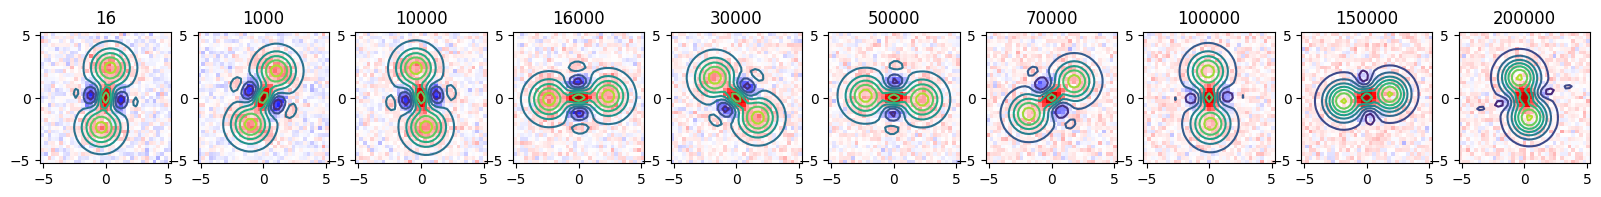

In [54]:
fig, axs = plt.subplots(1, len(data_array), figsize = (20, 20*len(data_array)))

popts = []
angles = []

for i, data in enumerate(data_array):
    scaling = 3
    xvec = x*scaling # i define it like this in case i want to slice x
    yvec = x*scaling
    X, Y = np.meshgrid(yvec, xvec)
    
    # xy_angle = np.array(np.unravel_index(np.argmin(data, axis=None), data.shape)) - (np.unravel_index(np.argmax(data, axis=None), data.shape)) 
    # print(xy_angle)
    # theta0 = np.arctan(xy_angle[1]/xy_angle[0]) -np.pi/2
    # print(np.rad2deg(theta0))
    #(xy_tuple, amplitude, sigma_x, sigma_y, beta_amp, theta, offset)
    initial_guess = (0.8,  0.8, 1, 1, np.pi/2, 0) # upper blob
    
    # find the lowest and maximal point and substract their coordinates
  

        
    popt, pcov = opt.curve_fit(char_func_cat, (X, Y), data.flatten(), p0=initial_guess, maxfev = 5000)
    popts.append(popt)
    angles.append(popt[4])
    data_fitted1 = char_func_cat((X, Y), *popt)

    axs[i].pcolormesh(X,Y, data, cmap="seismic", vmin = -1 , vmax = 1)
    axs[i].contour(yvec,xvec, data_fitted1.reshape(X.shape))
    axs[i].set_aspect("equal")
    axs[i].set_title(str(decay_times[i]))
plt.show()

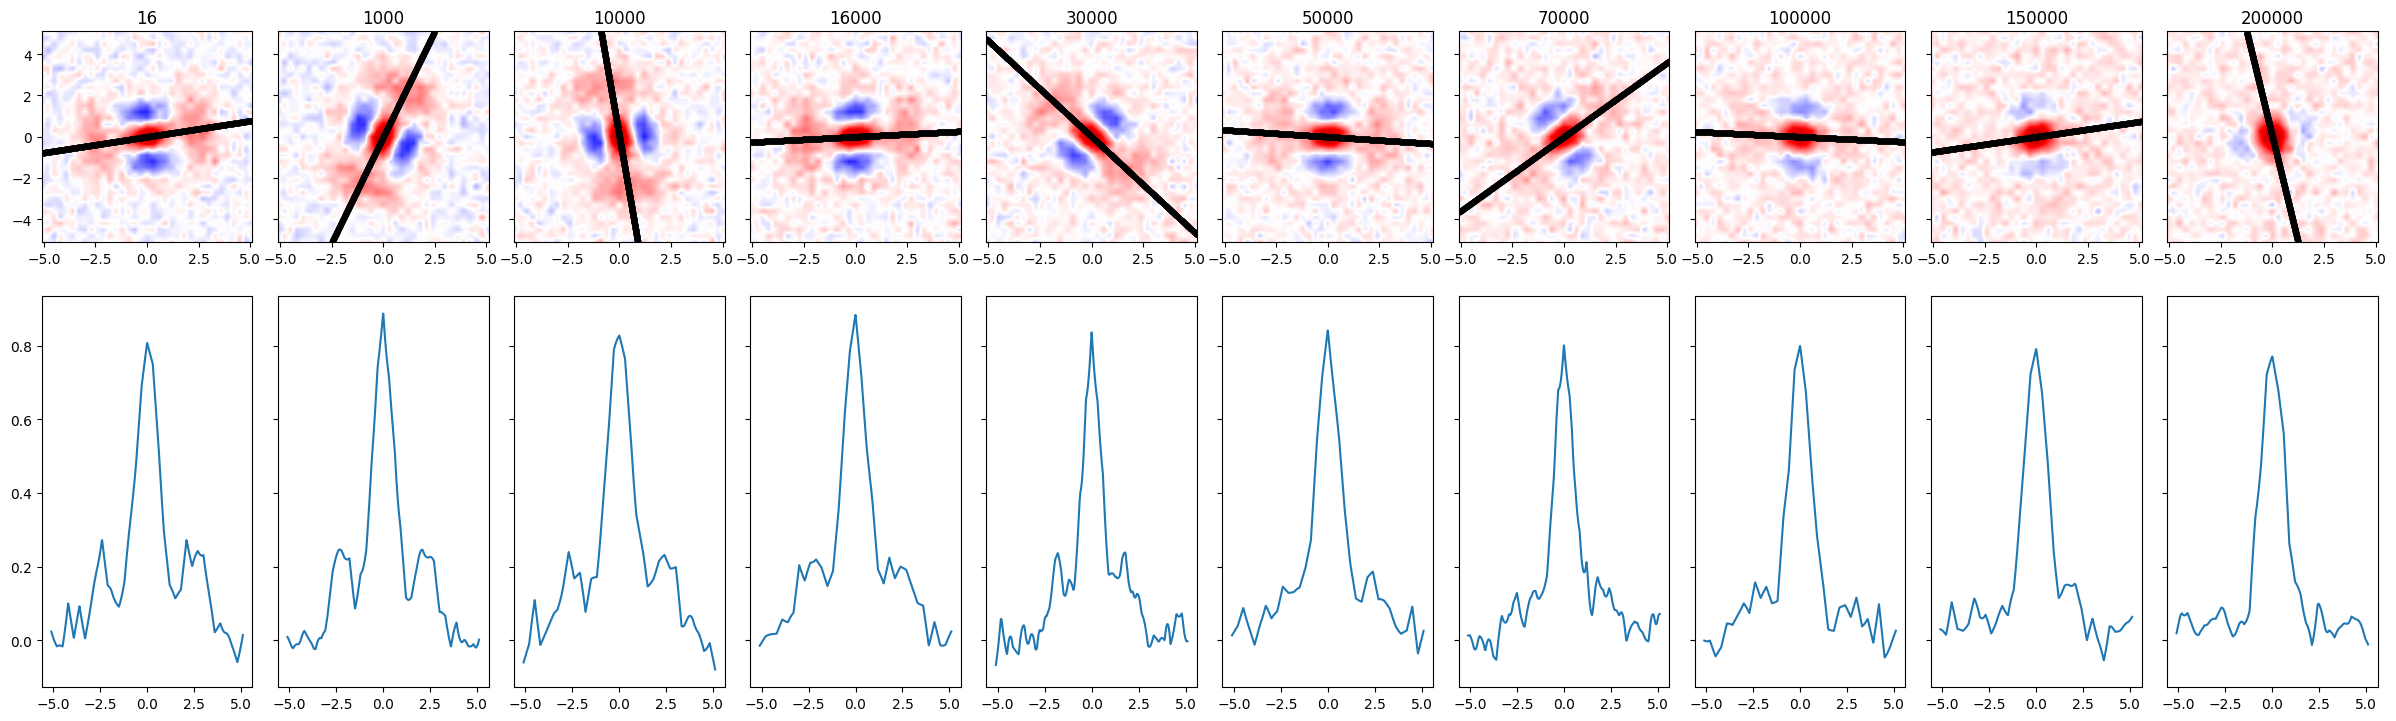

In [55]:

fig, axs = plt.subplots(2,len(data_array), sharey="row", figsize=(24,8))


db3_cut_array = []

for i, data in enumerate(data_array):
    angle = angles[i]
    if np.abs(angles[i])<np.deg2rad(15):
        data = data.T
        angle = np.pi/2-angles[i]
    #interpolate data
    func = interp2d(xvec,yvec,data, kind="linear")
    # define finer x,y arrays with same end values as data x,y
    x_inter = np.linspace(np.min(xvec),np.max(xvec), 1000)
    y_inter = np.linspace(np.min(xvec),np.max(xvec), 1000)
    
    # get x and y indicies for line cut and load the line cut in cut
    x_index, y_index = cut_indexes(y_inter, np.pi/2-angle)
    cut = []
    for j in range(len(x_index)):
        cut.append(float(func(x_index[j],y_index[j])))
    db3_cut_array.append(cut)
    axs[0][i].set_aspect("equal")
    axs[0][i].pcolormesh(x_inter, y_inter, func(x_inter,x_inter), vmin=-1, vmax=1 , cmap="seismic")
    axs[0][i].scatter(x_index, y_index, c='k', marker = '.')
    axs[0][i].set_title(str(decay_times[i]))
    axs[1][i].plot(x_inter,cut)
    plt.tight_layout()
plt.show()
    


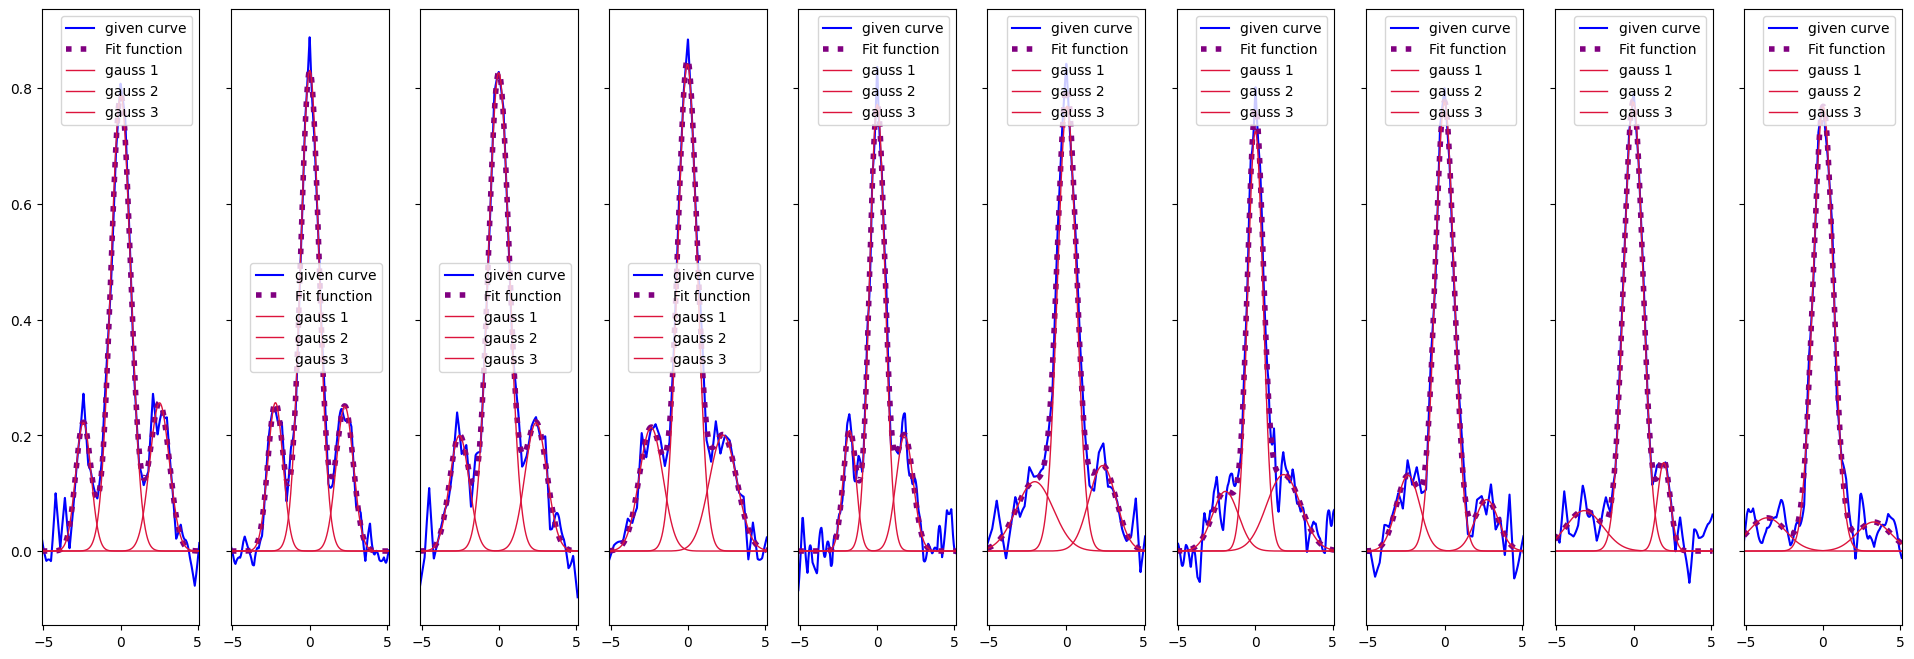

In [56]:

fig, axs = plt.subplots(1,len(db3_cut_array), sharey="row", figsize=(24,8))

fit_amp_3db = []
fit_amp_std_3db = []

for i, cut in enumerate(db3_cut_array):
    amp1 = 0.35
    sigma1 = 1
    cen1 = -3.5
    amp2 = 0.8
    sigma2 = 1
    cen2 = 0
    amp3 = 0.25
    sigma3 = 1
    cen3 = 3.5
    initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
    bounds = ([-np.inf, -np.inf, -np.inf,-np.inf, -np.inf, -0.9,-np.inf, -np.inf, -np.inf ],[np.inf, np.inf, 1.2,np.inf, np.inf, 1.2,np.inf, np.inf, 1.1 ]) 
       
    
    x = np.array(x_inter)
    y = np.array(cut)
    
    y0 = gauss_3(x, *initial_guess)

    popt, pcov = curve_fit(gauss_3, x, y, p0=initial_guess, bounds=bounds)
    fit_amp_3db.append((popt[0]+popt[6])/2)
    fit_amp_std_3db.append(np.sqrt(pcov[0][0]+pcov[6][6])/2)
    axs[i].plot(x, y, 'b', label="given curve")
    axs[i].plot(x, gauss_3(x, *popt), ls=':', label="Fit function", linewidth=4, color='purple')
    for j, (a, c, s )in enumerate( popt.reshape(-1, 3)):
        axs[i].plot(x, gauss_1(x, a, c, s), ls='-', label=f"gauss {j+1}", linewidth=1, color='crimson')
    axs[i].legend()
    axs[i].autoscale(axis='x', tight=True)
plt.show()


In [ ]:
plt.plot(x_inter[0:350],db3_cut_array[4][0:350])
blob_contrast_3dB = []

for i in range(len(db3_cut_array)):
    blob_contrast_3dB.append((np.max(db3_cut_array[i][:350] + np.max(db3_cut_array[i][650:])))/2)

### Load 6dB data

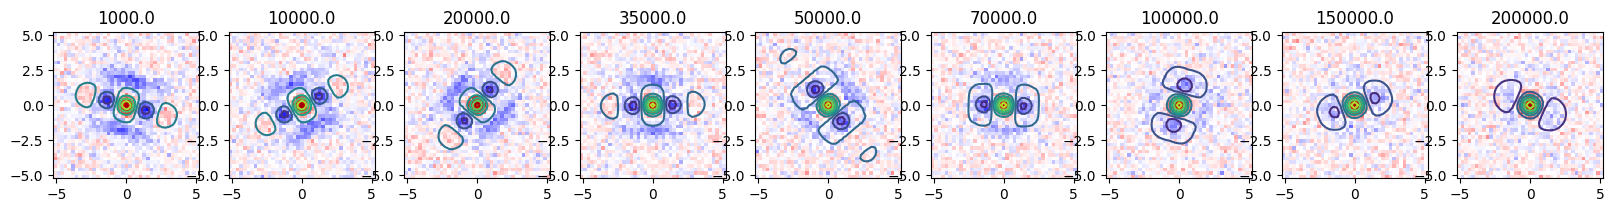

In [53]:
path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/"
file_end = '6db_oddcat.h5'



x, y, data_array, decay_times = load_triple_mask_decay(path, file_end , plot=False, thresh=thresh)
fig, axs = plt.subplots(1, len(data_array), figsize = (20, 20*len(data_array)))

angles_guess = np.array(angles_cat) + np.array([np.pi/2]*len(angles_cat)) # angles seem to be the same. hence, us them the cat angles as guess
popts = []
angles_6db = []
for i, data in enumerate(data_array):
    scaling = 3
    xvec = x*scaling # i define it like this in case i want to slice x
    yvec = x*scaling
    X, Y = np.meshgrid(yvec, xvec)

    #(xy_tuple, amplitude, sigma_x, sigma_y, beta_amp, theta, offset)
    initial_guess = (0.8,  0.8, 1, 1, angles_guess[i], 0) # upper blob

        
    popt, pcov = opt.curve_fit(char_func_fringe, (X, Y), data.flatten(), p0=initial_guess)
    popts.append(popt)
    angles_6db.append(popt[4])

    data_fitted1 = char_func_fringe((X, Y), *popt)

    axs[i].pcolormesh(X,Y, data, cmap="seismic", vmin = -1 , vmax = 1)
    axs[i].contour(yvec,xvec, data_fitted1.reshape(X.shape))
    axs[i].set_aspect("equal")
    axs[i].set_title(str(decay_times[i]))
plt.show()

In [44]:
angles_6db

[3.4120787807844266,
 2.663258747167929,
 2.2620158395208922,
 3.12383953092983,
 4.011121451512516,
 3.165693174774351,
 1.8553194925814573,
 2.7929665459008812,
 3.582683880496786]

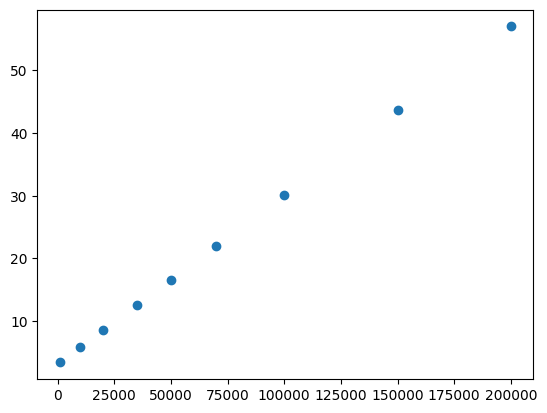

In [12]:
pis = np.array([0,1,2,3,4,6,9,13,17])*np.pi
fit_angles = np.array(angles_6db) + pis
plt.plot(decay_times, fit_angles, 'o')

f= 42903.59238927445
theta = 3.1343640697766895


Text(0.5, 1.0, '6db')

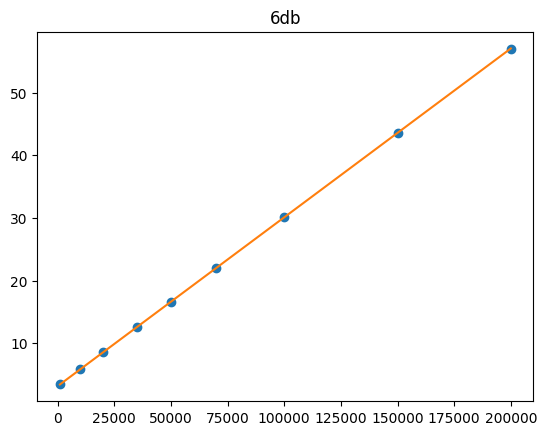

In [15]:
from scipy.optimize import curve_fit

def func(t,f,theta):
    return 2*np.pi*f*t+theta

popt, pcov = curve_fit(func,decay_times[:],fit_angles[:])

plt.plot(decay_times[:],fit_angles[:], "o")
plt.plot(decay_times[:],func(decay_times[:], *popt), )
print("f=", popt[0]*1e9)
print("theta =", popt[1])
plt.title("6db")

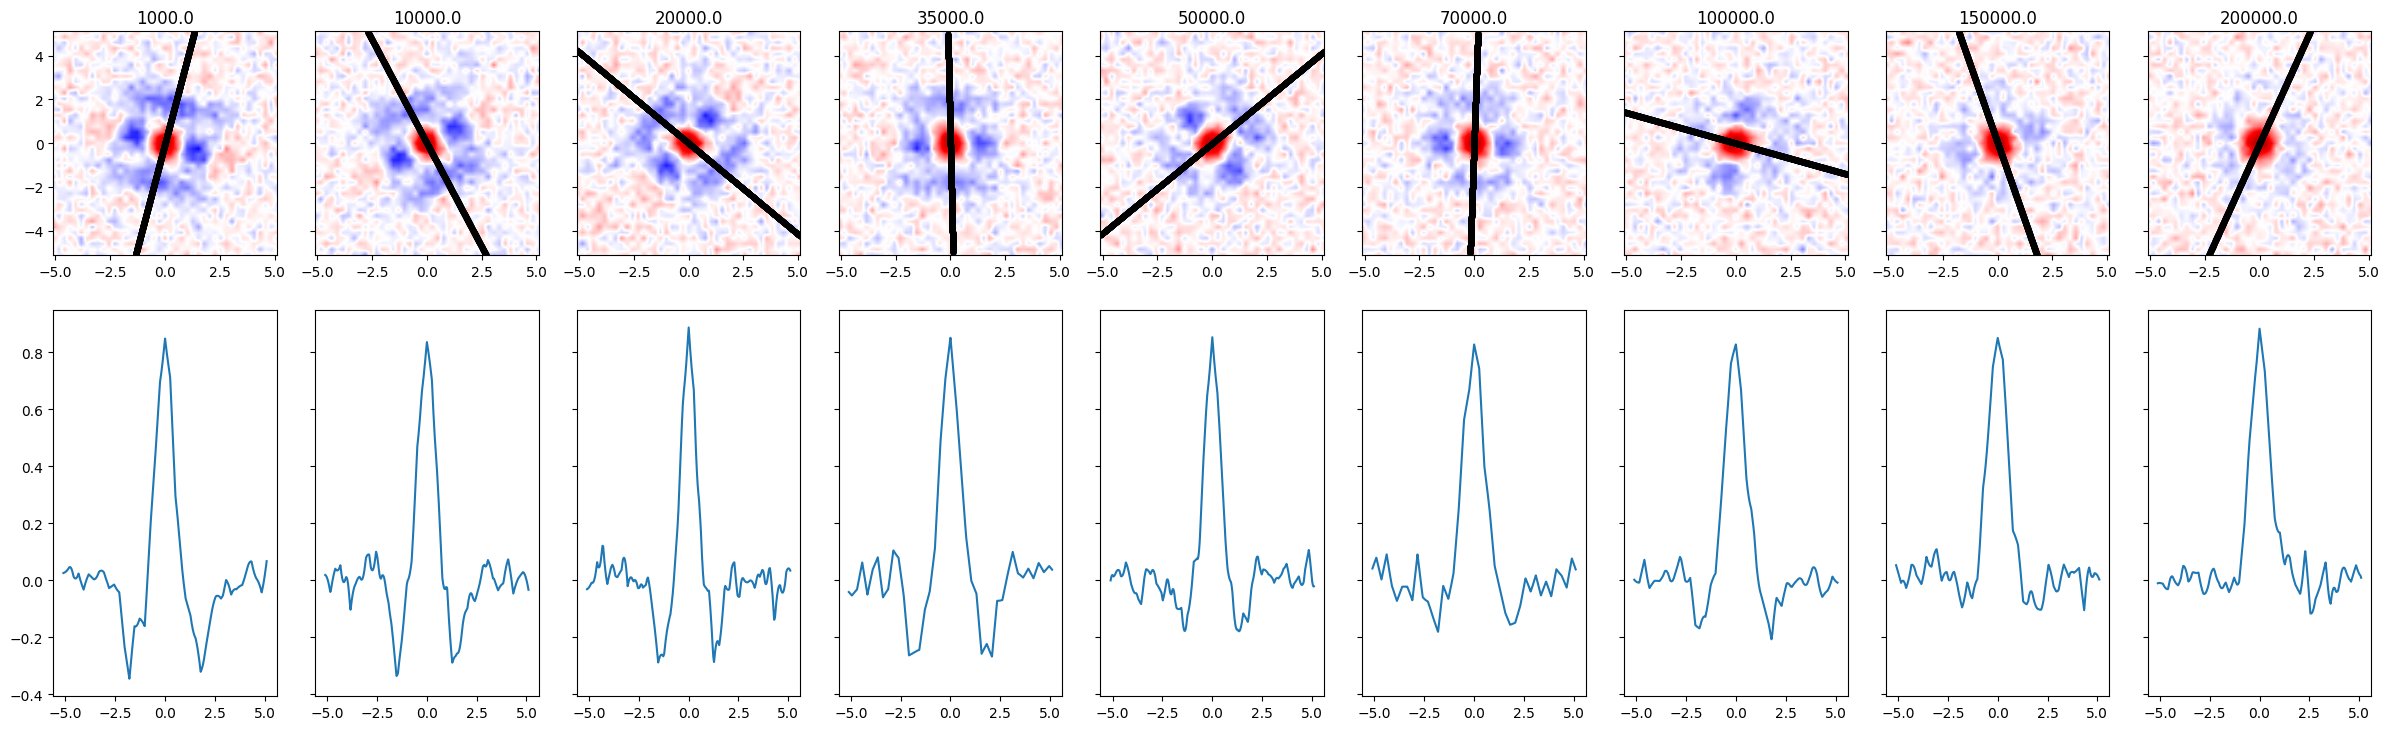

In [54]:

fig, axs = plt.subplots(2,len(data_array), sharey="row", figsize=(24,8))

db6_cut_array = []
for i, data in enumerate(data_array):
    angle = angles_6db[i]
    if np.abs(angles_6db[i])<np.deg2rad(15):
        data = data.T
        angle = np.pi/2-angles_6db[i]
    #interpolate data
    func = interp2d(xvec,yvec,data, kind="linear")
    # define finer x,y arrays with same end values as data x,y
    x_inter = np.linspace(np.min(xvec),np.max(xvec), 2000)
    y_inter = np.linspace(np.min(xvec),np.max(xvec), 2000)
    
    # get x and y indicies for line cut and load the line cut in cut
    x_index, y_index = cut_indexes(y_inter, np.pi/2-angle)
    cut = []
    for j in range(len(x_index)):
        cut.append(float(func(x_index[j],y_index[j])))
    db6_cut_array.append(cut)
    axs[0][i].set_aspect("equal")
    axs[0][i].pcolormesh(x_inter, y_inter, func(x_inter,x_inter), vmin=-1, vmax=1 , cmap="seismic")
    axs[0][i].scatter(x_index, y_index, c='k', marker = '.')
    axs[0][i].set_title(str(decay_times[i]))
    axs[1][i].plot(x_inter,cut)
    plt.tight_layout()
plt.show()
    


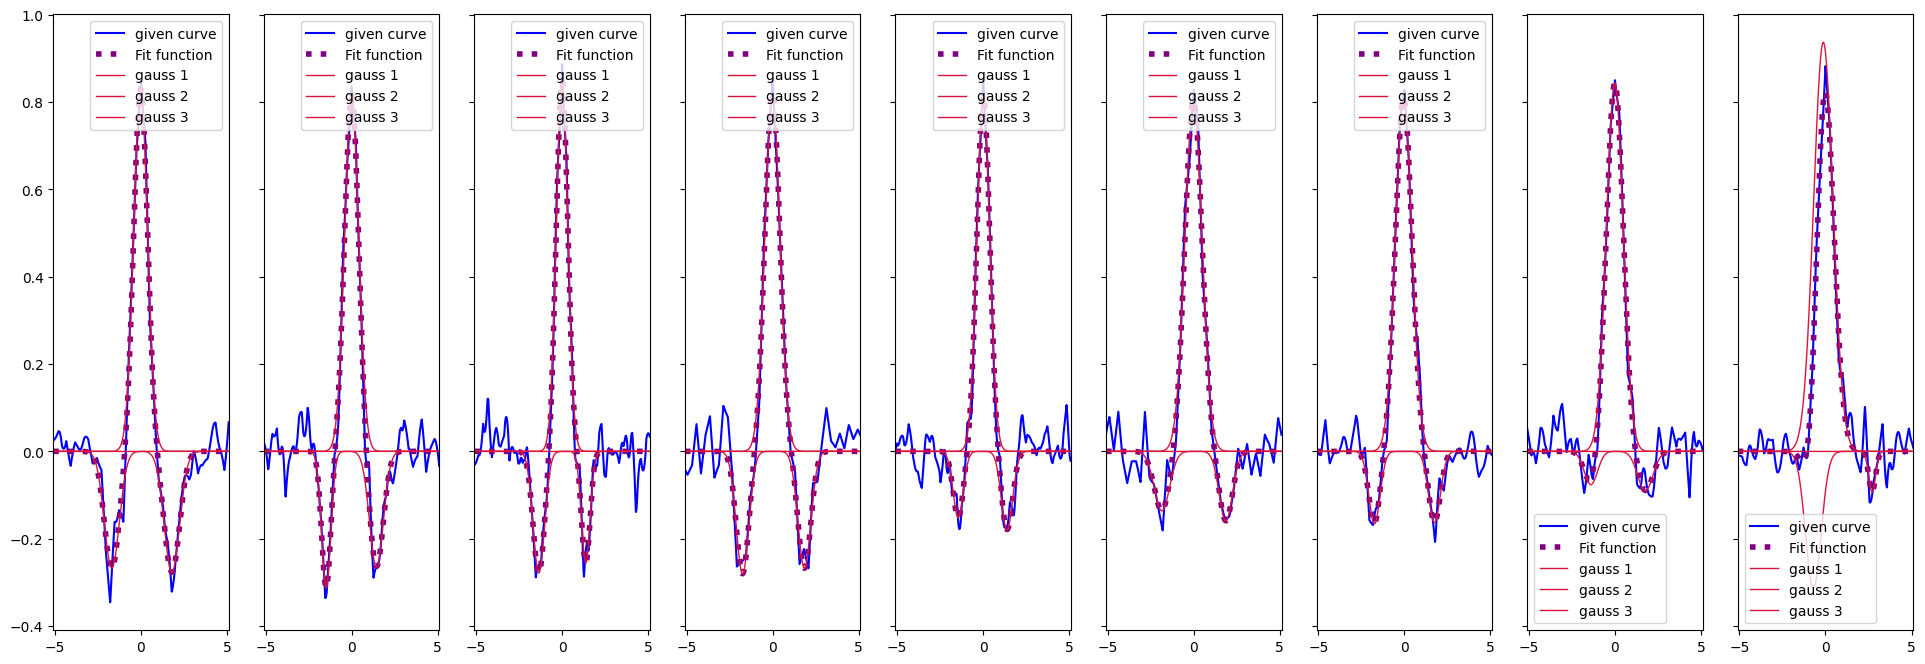

In [55]:

fig, axs = plt.subplots(1,len(db6_cut_array), sharey="row", figsize=(24,8))

fit_amp_6db = []
fit_amp_std_6db = []
for i, cut in enumerate(db6_cut_array):
    amp1 = -.38
    sigma1 = 0.3
    cen1 = -2
    amp2 = 0.8
    sigma2 = 0.3
    cen2 = 0
    amp3 = -0.4
    sigma3 = 0.3
    cen3 = 2
    initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
    bounds =([-1, -5, 0.2 ,0, -0.5, 0 ,-1,0, 0.2], 
             [0, 0, 0.45 ,1, 0.5, 1 ,0, 5, 0.45])
       
    
    x = np.array(x_inter)
    y = np.array(cut)
    
    y0 = gauss_3(x, *initial_guess)

    popt, pcov = curve_fit(gauss_3, x, y, p0=initial_guess, bounds=bounds)
    fit_amp_6db.append((popt[0]+popt[6])/2)
    fit_amp_std_6db.append(np.sqrt(pcov[0][0]+pcov[6][6])/2)
    axs[i].plot(x, y, 'b', label="given curve")
    axs[i].plot(x, gauss_3(x, *popt), ls=':', label="Fit function", linewidth=4, color='purple')
    for j, (a, c, s )in enumerate( popt.reshape(-1, 3)):
        axs[i].plot(x, gauss_1(x, a, c, s), ls='-', label=f"gauss {j+1}", linewidth=1, color='crimson')
    axs[i].legend()
    axs[i].autoscale(axis='x', tight=True)
plt.show()


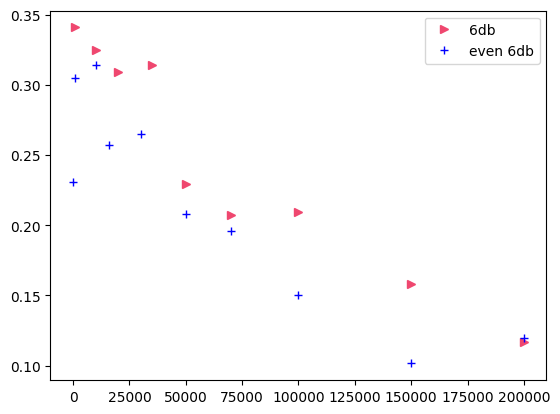

In [39]:
plt.plot(decay_times[:],np.array(fit_amp_6db[:])*-1, '>', label = '6db', color = '#ef476f')
plt.plot(times[:], cat_blob_amps[2], "+", label = 'even 6db',  color = 'blue')
plt.legend()

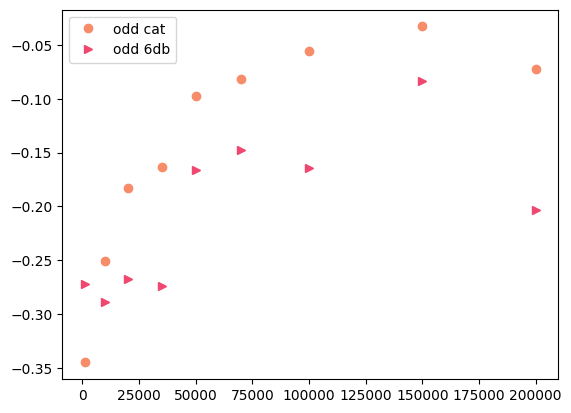

In [57]:
plt.plot(decay_times[:],np.array(fit_amp_cat[:]), "o", label = "odd cat",color = '#f78c6b'  )
plt.plot(decay_times[:],np.array(fit_amp_6db[:]), '>', label = 'odd 6db', color = '#ef476f')
plt.legend()

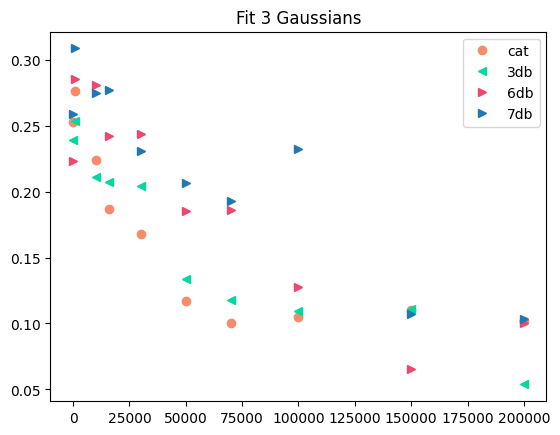

In [66]:


plt.plot(decay_times[:],fit_amp_cat[:], "o", label = "cat",color = '#f78c6b'  )
#plt.plot(decay_times[:],fit_amp_3db[:], '<', label = "3db" , color = '#06d6a0')
plt.plot(decay_times[:],fit_amp_6db[:], '>', label = '6db', color = '#ef476f')
#plt.plot(decay_times[:],fit_amp_7db[:], '>', label = '7db')
plt.title("Fit 3 Gaussians")
plt.legend()

<ErrorbarContainer object of 3 artists>

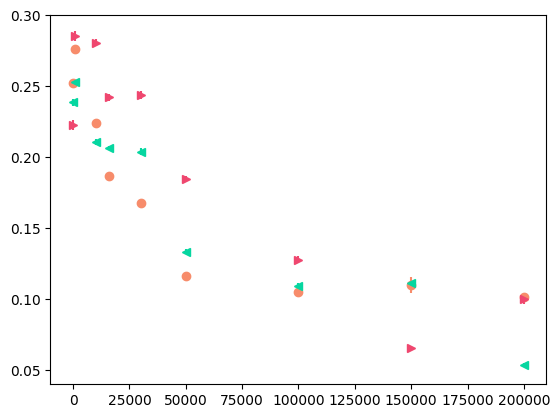

In [22]:
plt.errorbar(decay_times[decay_times!=70000][:],fit_amp_cat[:],  label = "cat",  yerr = fit_amp_std_cat[:], color = '#f78c6b',fmt = 'o'  )
plt.errorbar(decay_times[decay_times!=70000][:],fit_amp_3db[:],  label = "cat",  yerr = fit_amp_std_3db[:], color = '#06d6a0',  fmt='<')
plt.errorbar(decay_times[decay_times!=70000][:],fit_amp_6db[:],  label = "cat",  yerr = fit_amp_std_6db[:], color = '#ef476f',fmt='>')  

In [67]:
yvonne_lst = [decay_times, fit_amp_cat, fit_amp_3db, fit_amp_6db, fit_amp_7db]

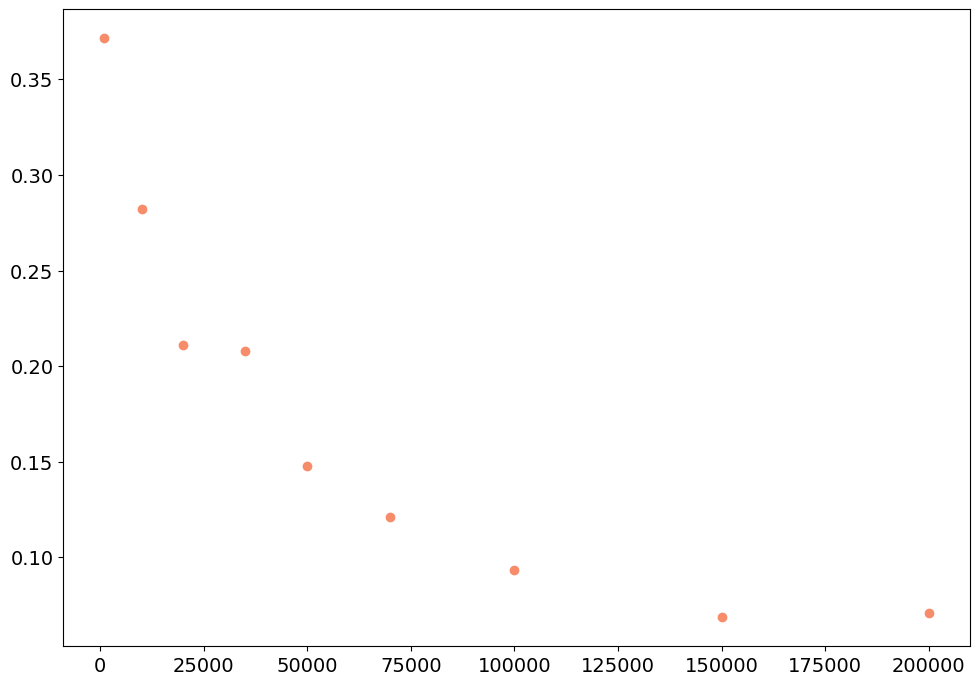

In [42]:


plt.plot(decay_times[:],fit_amp_cat[:], "o", label = "cat",color = '#f78c6b'  )

In [68]:
np.save("3gaussian_fit",arr=yvonne_lst)